# Состав космических лучей ультравысоких энергий

Эксперимент Telescope Array регистрирует широкие атмосферные ливни, вызванные космическими лучами ультравысоких энергий.
Предполагается,что первичные частицы протоны или ядра химических элементов.<br><br> 
Для каждого события в результате реконструкции определяются 16 наблюдаемых параметров (описание физического смысла параметров см. в работе [arXiv:1808.03680](https://arxiv.org/abs/1808.03680)). По адресу ftp://cluster.inr.ac.ru/pub/ML/TASD/ размещены результаты Монте-Карло моделирования эксперимента для ШАЛ, вызванных первичными протонами p.dat, ядрами гелия he.dat, азота n.dat и железа fe.dat. Кроме того, размещены три неизвестных смеси unknown1.dat, unknown2.dat, unknown3.dat. Известно, что в первом неизвестном наборе присутствуют только протоны и железо.<br><br>
Определить состав первичных частиц в каждом из трех неизвестных наборов. 

In [39]:
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams['figure.figsize'] = (7,7) # Make the figures a bit bigger

import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

from pandas.plotting import parallel_coordinates

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import PReLU, ReLU, LeakyReLU
from keras.utils import np_utils
from keras.optimizers import Adadelta
import keras

from keras.wrappers.scikit_learn import KerasClassifier

import xgboost as xgb

# 1. Load Data

In [2]:
path = "./data/"
ls = sorted(os.listdir(path))
ls

['fe.dat',
 'he.dat',
 'n.dat',
 'p.dat',
 'p.paramnames',
 'unknown1.dat',
 'unknown2.dat',
 'unknown3.dat']

In [3]:
col_names = [line.rstrip('\n') for line in open(path+'p.paramnames')]
fe_dat = pd.read_csv(path+'fe.dat', sep='\s+', header=None, names=col_names)
he_dat = pd.read_csv(path+'he.dat', sep='\s+', header=None, names=col_names)
n_dat = pd.read_csv(path+'n.dat', sep='\s+', header=None, names=col_names)
p_dat = pd.read_csv(path+'p.dat', sep='\s+', header=None, names=col_names)
test_set_1 = pd.read_csv(path+'unknown1.dat', sep='\s+', header=None, names=col_names)
test_set_2 = pd.read_csv(path+'unknown2.dat', sep='\s+', header=None, names=col_names)
test_set_3 = pd.read_csv(path+'unknown3.dat', sep='\s+', header=None, names=col_names)
fe_dat.head()

theta     S800  ndet  ndet_excluded      chi2  a_Linsley      AoP  \
0  39.57  27.5086    11              0  1.171620   0.410901  298.728   
1  44.31  15.0941    12              1  1.325450   0.347213  320.985   
2  30.56  30.6184    10              0  1.248640   0.522949  338.055   
3  28.60  45.1951    12              0  0.926937   0.381857  320.800   
4  16.05  30.1932     9              0  1.113990   0.652114  386.105   

   AoP_slope        S3      S4.5  total_signal     asymm  npeaks  \
0   -212.153  2.597293  3.510811       682.307  0.149334      68   
1   -300.142  3.049357  5.003008       118.441  0.254463      52   
2   -435.733  1.510791  1.785234       183.177  0.235445      62   
3   -254.926  1.759250  2.594949       236.977  0.262987      74   
4   -399.146  1.638644  2.213402       258.191  0.218733      63   

   npeaks_highest  asymmpeaks_u  asymmpeaks_l  
0              13             9             6  
1              11             7             7  
2              16             8             2  
3              15             6            14  
4              16            12             5

# 2. Test set 1

В первом тестовом наборе присутствуют только протоны и железо.

In [4]:
fe_dat['label'] = 'Fe'
p_dat['label'] = 'p'

train_set_1 = fe_dat.append(p_dat).sample(frac=1., random_state=1234)
X_1 = train_set_1.drop('label', axis=1)

labenc = LabelEncoder()
y_1 = labenc.fit_transform(train_set_1['label'])

train_set_1.head()

theta     S800  ndet  ndet_excluded     chi2  a_Linsley      AoP  \
9447   22.75  20.7472     7              0  4.46366   0.539785  406.423   
16705  25.34  29.5990     9              0  1.13434   0.710770  395.112   
6909   31.46  26.9533    11              0  1.41401   0.317610  430.729   
18292  32.28  23.9958     8              0  1.10844   0.418081  399.944   
3657   15.15  43.8133    10              0  1.44439   0.690760  393.902   

       AoP_slope        S3      S4.5  total_signal     asymm  npeaks  \
9447    -467.998  2.617278  3.509004       259.788  0.221393      51   
16705   -404.465  2.053552  2.203524       458.408  0.167795      77   
6909    -352.623  2.422483  4.197037       125.841  0.264932      73   
18292   -299.187  2.224910  2.776328       373.392  0.143381      71   
3657    -332.813  1.890399  2.303730       682.124  0.145482      76   

       npeaks_highest  asymmpeaks_u  asymmpeaks_l label  
9447                8            10             5     p  
16705              15            10             6    Fe  
6909               10             9             9    Fe  
18292              10             6             6    Fe  
3657               11             6             9     p

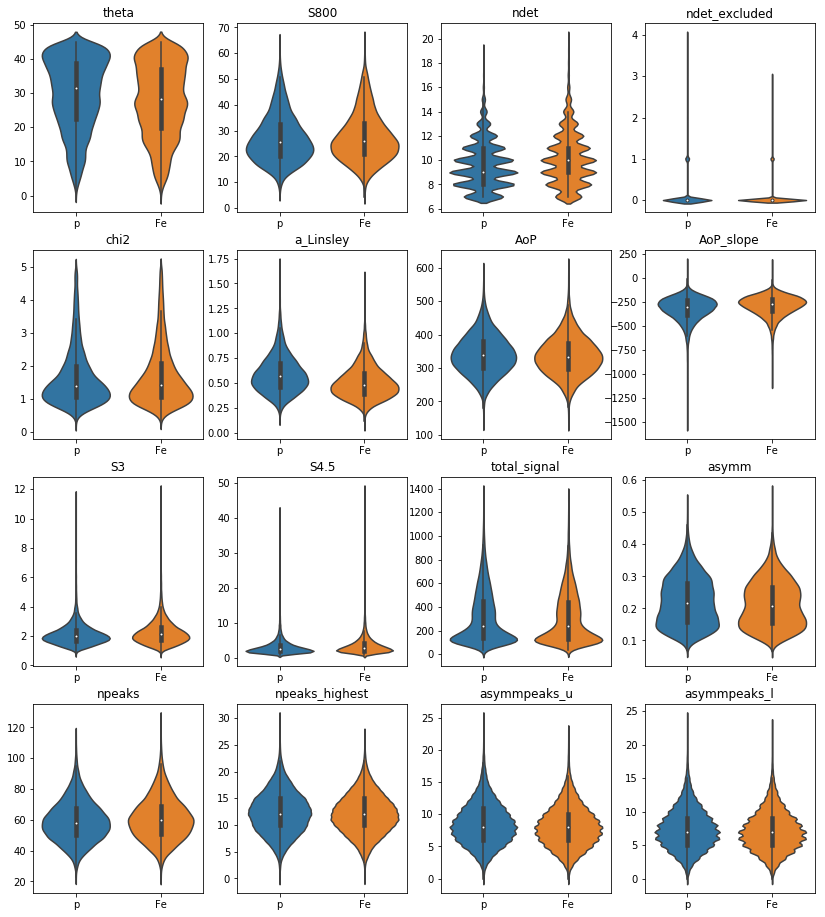

In [5]:
nr_rows = 4
nr_cols = 4

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*4))

for r in range(nr_rows):
    for c in range(nr_cols):
        sns.violinplot(x='label', y=train_set_1.columns.values[r*nr_cols+c], data=train_set_1, ax=axs[r][c])
        axs[r][c].set_ylabel(None)
        axs[r][c].set_xlabel(None)
        axs[r][c].set_title(train_set_1.columns.values[r*nr_cols+c])

plt.show()

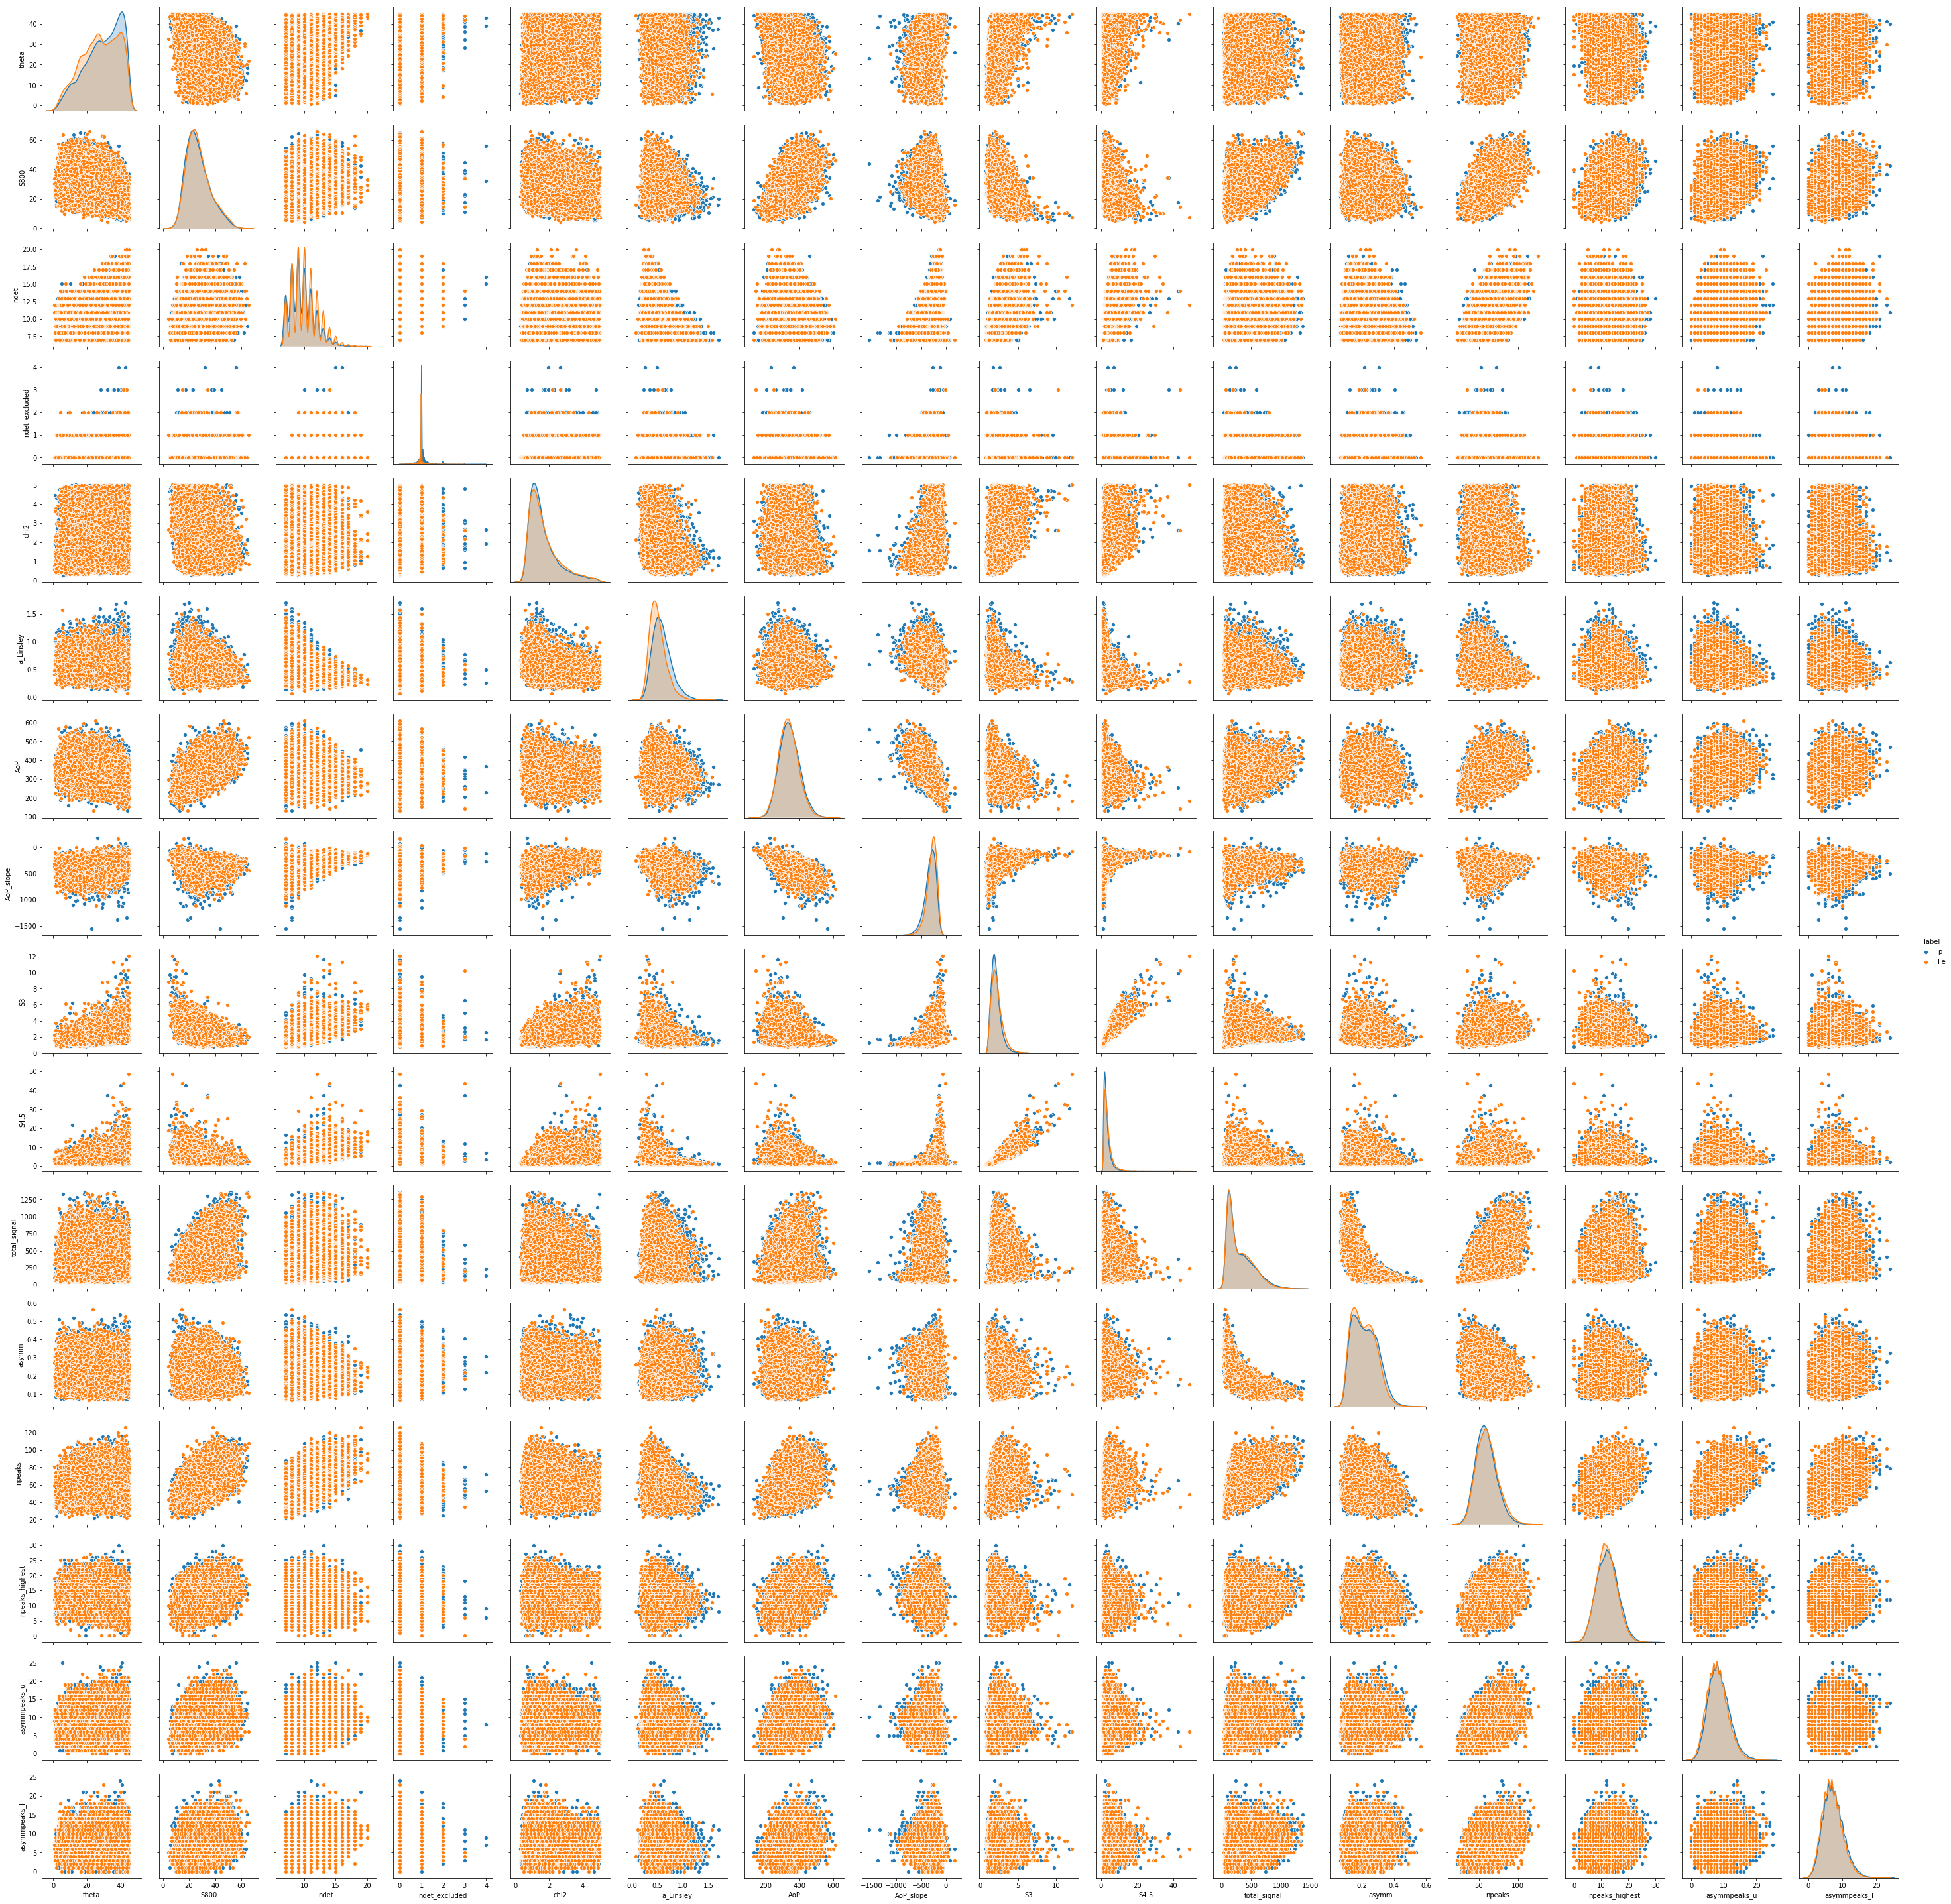

In [16]:
sns.pairplot(train_set_1, hue='label')
plt.show()

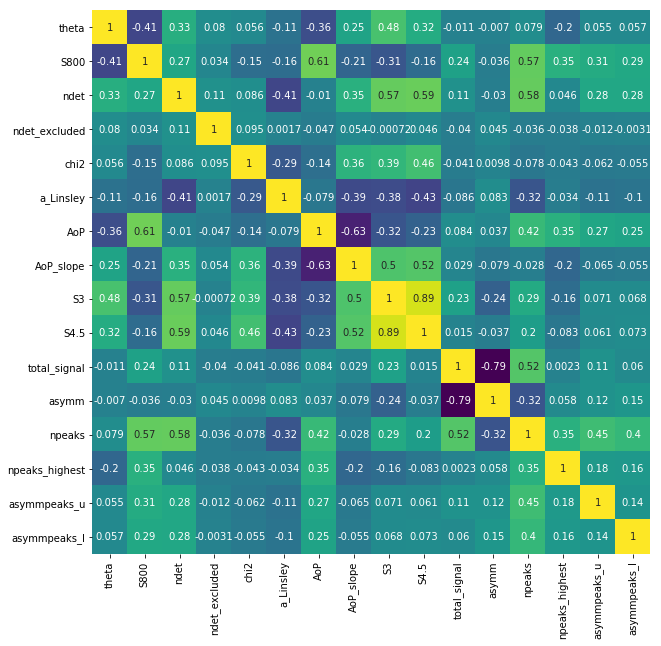

In [6]:
f, ax = plt.subplots(figsize=(10, 10))
corr = train_set_1.corr()
sns.heatmap(
    corr,
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
    annot=True,
    cmap='viridis',
    cbar=False
)
plt.show()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.1, random_state=1234)

'''
param_test = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2),
 'learning_rate':[0.2, 0.1, 0.01],
 'gamma':[0, 0.1, 0.2, 0.3]
}

model = GridSearchCV(xgb.XGBClassifier(
 n_estimators=200,
 subsample=0.8,
 colsample_bytree=0.8,
 objective='binary:logistic',
 nthread=4,
 seed=27
), param_grid=param_test, cv=5, n_jobs=-1, verbose=1)
'''

model = xgb.XGBClassifier(
    n_estimators=200,
    gamma=0.2,
    learning_rate=0.2,
    max_depth=3,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    nthread=12,
    seed=1234
)

model.fit(X_train, y_train)
model.score(X_test, y_test)

0.64975

In [6]:
model_1 = Sequential()
model_1.add(Dense(128, activation='relu', input_dim=16))
model_1.add(Dropout(0.5))
model_1.add(Dense(128, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(1, activation='sigmoid'))
model_1.compile(optimizer ='adam', loss='binary_crossentropy', metrics =['accuracy'])

scaler = StandardScaler()
X_1_nn = scaler.fit_transform(X_1)
X_train, X_test, y_train, y_test = train_test_split(X_1_nn, y_1, test_size=0.1, random_state=1234)

'''
callbacks = [
    keras.callbacks.ModelCheckpoint('best_weights.h5', monitor='val_acc',
                                    save_best_only=True, save_weights_only=True),  # save best model
    keras.callbacks.EarlyStopping(monitor='val_acc', patience=20,
                                  verbose=1, restore_best_weights=True)  # early stop
]

model_1.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=callbacks, batch_size=10)
'''

model_1.load_weights('best_weights.h5')
model_1.evaluate(X_test, y_test)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/home/sakar/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/sakar/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


4000/4000 [==============================] - 1s 147us/step


[0.6221190092563629, 0.6665]

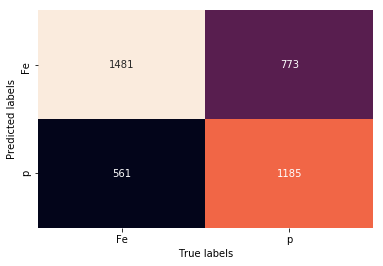

In [12]:
a = confusion_matrix(model_1.predict_classes(X_test), y_test)

sns.heatmap(
    a, 
    annot=True,
    fmt="d",
    xticklabels=labenc.inverse_transform([0,1]),
    yticklabels=labenc.inverse_transform([0,1]),
    cbar=False
)
plt.xlabel("True labels")
plt.ylabel("Predicted labels")
plt.show()

In [27]:
Unknown_1 = scaler.transform(test_set_1)

p_num = np.sum(
    labenc.inverse_transform(
        (model_1.predict_classes(Unknown_1)).astype(int).ravel()
    ) == 'p'
)

p_num_fixed = p_num * (a[0].sum() / a[1].sum()) / (a[:,0].sum() / a[:,1].sum())
p_rate = p_num_fixed / Unknown_1.shape[0]

print("Unknown set 1 consists of {0:.2%} protons and {1:.2%} Fe nuclei".format(p_rate, 1-p_rate))

Unknown set 1 consists of 59.34% protons and 40.66% Fe nuclei


/home/sakar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


# 3. Other sets

In [43]:
fe_dat['label'] = 'Fe'
p_dat['label'] = 'p'
n_dat['label'] = 'n'
he_dat['label'] = 'He'

total_set = fe_dat.append(p_dat).append(n_dat).append(he_dat)
total_set = total_set.sample(frac=1., random_state=1234)

X_total = total_set.drop('label', axis=1)
#y_total = pd.get_dummies(total_set['label'])
labenc = LabelEncoder()
y_total = labenc.fit_transform(total_set['label'])

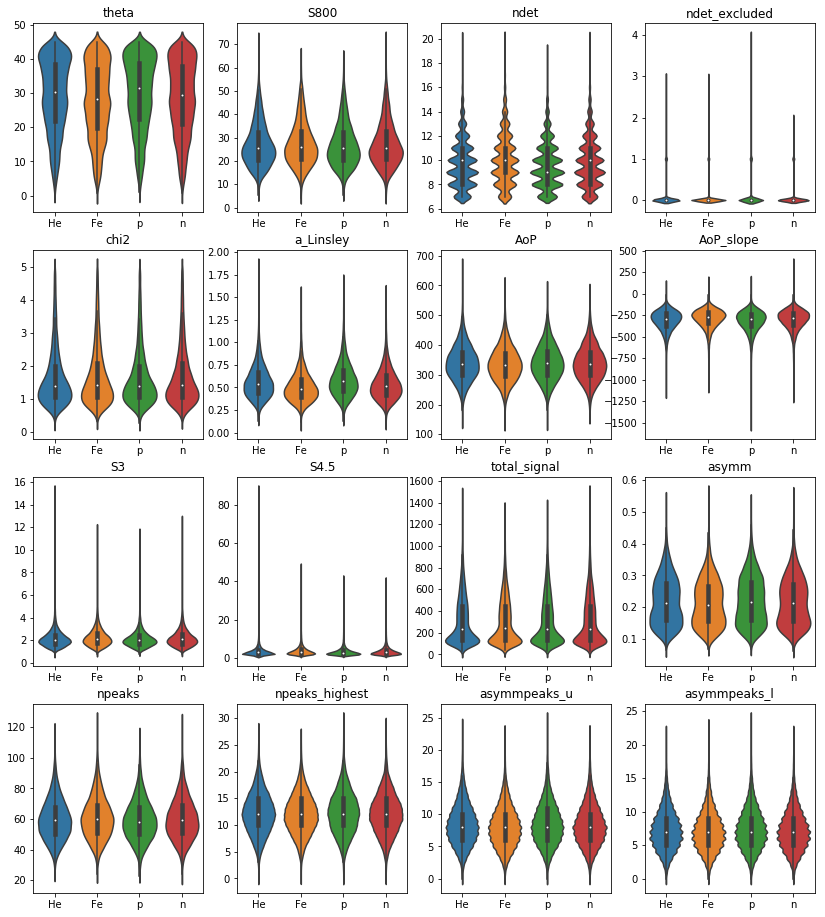

In [89]:
nr_rows = 4
nr_cols = 4

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*4))

for r in range(nr_rows):
    for c in range(nr_cols):
        sns.violinplot(x='label', y=total_set.columns.values[r*nr_cols+c], data=total_set, ax=axs[r][c])
        axs[r][c].set_ylabel(None)
        axs[r][c].set_xlabel(None)
        axs[r][c].set_title(total_set.columns.values[r*nr_cols+c])

plt.show()

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_total, y_total, test_size=0.1, random_state=1234)

model = xgb.XGBClassifier(
    n_estimators=200,
    gamma=0.2,
    learning_rate=0.2,
    max_depth=3,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softmax',
    nthread=12,
    seed=1234
)

model.fit(X_train, y_train)
model.score(X_test, y_test)

ValueError: bad input shape (72000, 4)

In [53]:
model = Sequential()
model.add(Dense(512, input_dim=16))
model.add(ReLU())
model.add(Dropout(0.5))
model.add(Dense(512))
model.add(ReLU())
model.add(Dropout(0.5))
model.add(Dense(4, activation='sigmoid'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

scaler = StandardScaler()
X_total_nn = scaler.fit_transform(X_total)

X_train, X_test, y_train, y_test = train_test_split(X_total_nn, y_total, test_size=0.1, random_state=1234)

callbacks = [
    keras.callbacks.ModelCheckpoint('best_weights_total.h5', monitor='val_acc',
                                    save_best_only=True, save_weights_only=True),  # save best model
    keras.callbacks.EarlyStopping(monitor='val_acc', patience=20,
                                  verbose=1, restore_best_weights=True)  # early stop
]

model.fit(X_train, y_train, epochs=100, callbacks=callbacks, verbose=1,
          batch_size=32, validation_data=(X_test, y_test))
model.evaluate(X_test, y_test)

/home/sakar/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/sakar/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Epoch 1/50
72000/72000 [==============================] - 8s 112us/step - loss: 1.8941e-05 - acc: 0.3078
Epoch 2/50
72000/72000 [==============================] - 7s 93us/step - loss: 1.8784e-05 - acc: 0.3224
Epoch 3/50
72000/72000 [==============================] - 7s 94us/step - loss: 1.8741e-05 - acc: 0.3231
Epoch 4/50
72000/72000 [==============================] - 7s 97us/step - loss: 1.8715e-05 - acc: 0.3268
Epoch 5/50
72000/72000 [==============================] - 7s 93us/step - loss: 1.8691e-05 - acc: 0.3294
Epoch 6/50
72000/72000 [==============================] - 7s 92us/step - loss: 1.8692e-05 - acc: 0.3281
Epoch 7/50
72000/72000 [==============================] - 7s 92us/step - loss: 1.8676e-05 - acc: 0.3291
Epoch 8/50
72000/72000 [==============================] - 7s 95us/step - loss: 1.8670e-05 - acc: 0.3284
Epoch 9/50
72000/72000 [==============================] - 7s 99us/step - loss: 1.8648e-05 - acc: 0.3323
Epoch 10/50
72000/72000 [==============================] - 7s 9

0.322875

8000/8000 [==============================] - 0s 23us/step


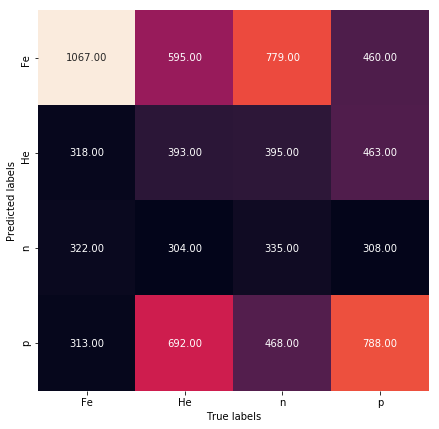

In [56]:
a = confusion_matrix(boosted_ann.predict(X_test), y_test)# / len(y_test.index)*4

sns.heatmap(
    a, 
    annot=True,
    fmt=".2f",
    xticklabels=labenc.inverse_transform([0,1,2,3]),
    yticklabels=labenc.inverse_transform([0,1,2,3]),
    cbar=False
)
plt.xlabel("True labels")
plt.ylabel("Predicted labels")
plt.show()

In [57]:
unknown1 = scaler.transform(test_set_1)
unknown2 = scaler.transform(test_set_2)
unknown3 = scaler.transform(test_set_3)

fe_mult = a[:,0].sum() / a[0].sum()
he_mult = a[:,1].sum() / a[1].sum()
n_mult = a[:,2].sum() / a[2].sum()
p_mult = a[:,3].sum() / a[3].sum()

u1_fe_frac = (model.predict_classes(unknown1) == 0).sum() / unknown1.shape[0] * fe_mult
u1_he_frac = (model.predict_classes(unknown1) == 1).sum() / unknown1.shape[0] * he_mult
u1_n_frac = (model.predict_classes(unknown1) == 2).sum() / unknown1.shape[0] * n_mult
u1_p_frac = (model.predict_classes(unknown1) == 3).sum() / unknown1.shape[0] * p_mult

print(f"Unknown set 1 consists of {u1_fe_frac:.2%} Fe nuclei, {u1_he_frac:.2%} He nuclei, {u1_n_frac:.2%} N nuclei and {u1_p_frac:.2%} protons")

u2_fe_frac = (model.predict_classes(unknown2) == 0).sum() / unknown2.shape[0] * fe_mult
u2_he_frac = (model.predict_classes(unknown2) == 1).sum() / unknown2.shape[0] * he_mult
u2_n_frac = (model.predict_classes(unknown2) == 2).sum() / unknown2.shape[0] * n_mult
u2_p_frac = (model.predict_classes(unknown2) == 3).sum() / unknown2.shape[0] * p_mult

print(f"Unknown set 2 consists of {u2_fe_frac:.2%} Fe nuclei, {u2_he_frac:.2%} He nuclei, {u2_n_frac:.2%} N nuclei and {u2_p_frac:.2%} protons")

u3_fe_frac = (model.predict_classes(unknown3) == 0).sum() / unknown3.shape[0] * fe_mult
u3_he_frac = (model.predict_classes(unknown3) == 1).sum() / unknown3.shape[0] * he_mult
u3_n_frac = (model.predict_classes(unknown3) == 2).sum() / unknown3.shape[0] * n_mult
u3_p_frac = (model.predict_classes(unknown3) == 3).sum() / unknown3.shape[0] * p_mult

print(f"Unknown set 3 consists of {u3_fe_frac:.2%} Fe nuclei, {u3_he_frac:.2%} He nuclei, {u3_n_frac:.2%} N nuclei and {u3_p_frac:.2%} protons")

/home/sakar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.
/home/sakar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
/home/sakar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


Unknown set 1 consists of 27.62% Fe nuclei, 27.77% He nuclei, 12.18% N nuclei and 27.29% protons
Unknown set 2 consists of 29.37% Fe nuclei, 28.27% He nuclei, 13.43% N nuclei and 23.97% protons
Unknown set 3 consists of 31.97% Fe nuclei, 27.54% He nuclei, 14.02% N nuclei and 20.81% protons


In [58]:
train_set_4 = he_dat.append(p_dat).sample(frac=1., random_state=1234)
X_1 = train_set_4.drop('label', axis=1)

labenc = LabelEncoder()
y_1 = labenc.fit_transform(train_set_4['label'])

train_set_4.head()

theta     S800  ndet  ndet_excluded      chi2  a_Linsley      AoP  \
9447   22.75  20.7472     7              0  4.463660   0.539785  406.423   
16705  39.94  22.7600    12              0  0.999853   0.516274  329.525   
6909   39.64  29.6892    11              0  2.329850   0.380443  302.358   
18292  20.63  22.5875    10              0  1.827650   0.531842  260.557   
3657   15.15  43.8133    10              0  1.444390   0.690760  393.902   

       AoP_slope        S3      S4.5  total_signal     asymm  npeaks  \
9447    -467.998  2.617278  3.509004       259.788  0.221393      51   
16705   -224.153  2.642421  4.823067       197.669  0.238380      66   
6909    -197.573  2.864220  5.555657       819.340  0.106681      69   
18292   -169.381  2.403285  4.770913       131.485  0.242461      49   
3657    -332.813  1.890399  2.303730       682.124  0.145482      76   

       npeaks_highest  asymmpeaks_u  asymmpeaks_l label  
9447                8            10             5     p  
16705              17            12            11    He  
6909                9             9             8    He  
18292              10             3             4    He  
3657               11             6             9     p